In [1]:
import mxnet as mx
from os import path as osp
import glob
import re
import scipy.io as sio
from mxnet import autograd, gluon, image, init, nd
import numpy as np
from matplotlib import pyplot as plt
import cv2

In [2]:

class Market1501(object):

    dataset_dir = 'Market-1501-v15.09.15'

    def __init__(self, root='', **kwargs):
        self.dataset_dir = osp.join(root, self.dataset_dir)
        self.train_dir = osp.join(self.dataset_dir, 'bounding_box_train')
        self.query_dir = osp.join(self.dataset_dir, 'query')
        self.gallery_dir = osp.join(self.dataset_dir, 'bounding_box_test')

        self._check_before_run()

        train, num_train_pids, num_train_imgs = self._process_dir(self.train_dir, relabel=True)
        query, num_query_pids, num_query_imgs = self._process_dir(self.query_dir, relabel=False)
        gallery, num_gallery_pids, num_gallery_imgs = self._process_dir(self.gallery_dir, relabel=False)
        num_total_pids = num_train_pids + num_query_pids
        num_total_imgs = num_train_imgs + num_query_imgs + num_gallery_imgs

        print("=> Market1501 loaded")
        print("Dataset statistics:")
        print("  ------------------------------")
        print("  subset   | # ids | # images")
        print("  ------------------------------")
        print("  train    | {:5d} | {:8d}".format(num_train_pids, num_train_imgs))
        print("  query    | {:5d} | {:8d}".format(num_query_pids, num_query_imgs))
        print("  gallery  | {:5d} | {:8d}".format(num_gallery_pids, num_gallery_imgs))
        print("  ------------------------------")
        print("  total    | {:5d} | {:8d}".format(num_total_pids, num_total_imgs))
        print("  ------------------------------")

        self.train = train
        self.query = query
        self.gallery = gallery

        self.num_train_pids = num_train_pids
        self.num_query_pids = num_query_pids
        self.num_gallery_pids = num_gallery_pids

    def _check_before_run(self):
        """Check if all files are available before going deeper"""
        if not osp.exists(self.dataset_dir):
            raise RuntimeError("'{}' is not available".format(self.dataset_dir))
        if not osp.exists(self.train_dir):
            raise RuntimeError("'{}' is not available".format(self.train_dir))
        if not osp.exists(self.query_dir):
            raise RuntimeError("'{}' is not available".format(self.query_dir))
        if not osp.exists(self.gallery_dir):
            raise RuntimeError("'{}' is not available".format(self.gallery_dir))

    def _process_dir(self, dir_path, relabel=False):
        img_paths = glob.glob(osp.join(dir_path, '*.jpg'))
        pattern = re.compile(r'([-\d]+)_c(\d)')

        pid_container = set()
        for img_path in img_paths:
            pid, _ = map(int, pattern.search(img_path).groups())
            if pid == -1: continue  # junk images are just ignored
            pid_container.add(pid)
        pid2label = {pid: label for label, pid in enumerate(pid_container)}

        dataset = []
        for img_path in img_paths:
            pid, camid = map(int, pattern.search(img_path).groups())
            if pid == -1:
                continue  # junk images are just ignored
            assert 0 <= pid <= 1501  # pid == 0 means background
            assert 1 <= camid <= 6
            camid -= 1  # index starts from 0
            if relabel: pid = pid2label[pid]
            dataset.append((img_path, pid, camid))

        num_pids = len(pid_container)
        num_imgs = len(dataset)
        return dataset, num_pids, num_imgs



__factory = {
    'market': Market1501
}


def get_names():
    return __factory.keys()


def init_dataset(name, *args, **kwargs):
    if name not in __factory.keys():
        raise KeyError("Unknown datasets: {}".format(name))
    return __factory[name](*args, **kwargs)


dataset=Market1501()

=> Market1501 loaded
Dataset statistics:
  ------------------------------
  subset   | # ids | # images
  ------------------------------
  train    |   751 |    12936
  query    |   750 |     3368
  gallery  |   751 |    15913
  ------------------------------
  total    |  1501 |    32217
  ------------------------------


In [3]:
ctx=mx.gpu(0)


load_data = sio.loadmat('result_res.mat')
query_feature =nd.array(load_data['query_f'],ctx=ctx)
query_cam = load_data['query_cam'][0]
# query_label = nd.array([result['query_label'][0]],ctx=ctx)
query_label = load_data['query_label'][0]
# print (query_cam)
gallery_feature = nd.array(load_data['gallery_f'],ctx=ctx)
gallery_cam = load_data['gallery_cam'][0]
gallery_label = load_data['gallery_label'][0]

In [4]:

m, n = query_feature.shape[0], gallery_feature.shape[0]
distmat = nd.power(query_feature, 2).sum(axis=1, keepdims=True).broadcast_to((m, n)) + \
          nd.power(gallery_feature, 2).sum(axis=1, keepdims=True).broadcast_to((n, m)).T
distmat = distmat - 2 * nd.dot(query_feature, gallery_feature.T)
distmat = distmat.asnumpy()
indices = np.argsort(distmat, axis=1) #距离排名(最小的为0，)
# matches = (gallery_label[indices] == query_label[:, np.newaxis]).astype(np.int32)

print (indices.shape)
#     q_pid = q_pids[q_idx]#这个query
#     q_camid = q_camids[q_idx]


print (query_feature)


(3368, 15913)

[[0.33143008 0.16171177 0.01207545 ... 0.1322572  0.00249436 0.11110694]
 [0.17062835 0.22871056 0.01154421 ... 0.13354878 0.0051675  0.11487585]
 [0.25866038 0.19848637 0.01376354 ... 0.14291723 0.00718198 0.11518764]
 ...
 [0.25399294 0.30149636 0.00946194 ... 0.13523652 0.00077859 0.13870597]
 [0.2851218  0.26700488 0.02753805 ... 0.11345125 0.00135294 0.13835977]
 [0.29245934 0.29264453 0.01667451 ... 0.12755328 0.00180816 0.09853165]]
<NDArray 3368x2048 @gpu(0)>


query image is '342'
(128, 64, 3)
the 0th result image is '342'
the 1th result image is '252'
the 2th result image is '252'
the 3th result image is '342'
the 4th result image is '342'
the 5th result image is '672'
the 6th result image is '252'
the 7th result image is '252'
the 8th result image is '252'
the 9th result image is '342'


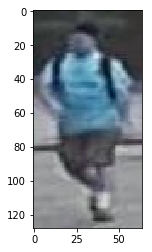

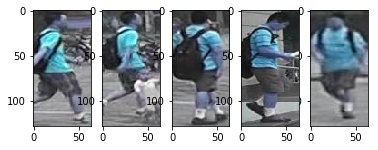

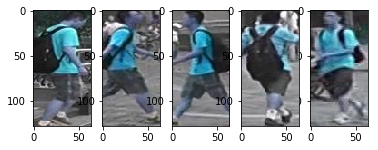

In [5]:
query_number=777



print("query image is '{}'".format(dataset.query[query_number][1]))
query_img=cv2.imread(dataset.query[query_number][0])
plt.imshow(query_img)
print(nd.array(query_img).shape)
index=indices[query_number][0:10]
# idx
for i in range(5):
    plt.figure(2)                # 第一个图形
    plt.subplot('15'+str(i)) 
    print("the "+str(i)+"th result image is '{}'".format(dataset.gallery[index[i]][1]))
    
#     print (gallery_label[index[i]])
    target_img=cv2.imread(dataset.gallery[index[i]][0])
    plt.imshow(target_img)
    
for i in range(5,10):
    plt.figure(3)                # 第一个图形
    plt.subplot('15'+str(i-5)) 
    print("the "+str(i)+"th result image is '{}'".format(dataset.gallery[index[i]][1]))
    target_img=cv2.imread(dataset.gallery[index[i]][0])
    plt.imshow(target_img)
